추론을 기반으로 한 단어의 분산표현. 추론 과정에서 신경망을 이용하는데 여기서 word2vec이 등장한다.

## 이번장의 목표 : 간단한 word2vec 구현

# 3.1 추론기반 기법과 신경망

## 3.1.1 통계 기반 기법의 문제점

통계 기반 기법은 주변 단어의 빈도를 가지고 단어를 표현했다. (동시 발생 행렬을 만들고, SVD를 적용해 단어의 분산 표현을 얻음) 이 방식은 대규모 말뭉치를 다룰 때 문제가 된다.

* 통계 기반 기법 : 전체 통계를 이용해 한번의 계산과정으로 단어의 분산 표현을 얻는다.
* 추론 기반 기법 : 미니 배치 학습을 이용해 순차적으로 학습한다.
=> 계산량이 클 때도 데이터를 작게 나눠 학습시키기 때문에 신경망을 학습시킬 수 있다. 

![image](https://user-images.githubusercontent.com/63278762/134807641-fa6784d5-67af-476e-9938-641c0c38f6a9.png)

## 3.1.2 추론 기반 기법 개요

![image](https://user-images.githubusercontent.com/63278762/134807686-e3b40da7-e497-487e-86e4-02b806354c07.png)

주변 단어를 이용해 "?"에 들어갈 단어를 추측하는 것. => 추론 문제를 풀고 학습하는 것이 "추론 기반 기법" 이다.    
'모델관점'에서 보면 다음 그림처럼 보인다.

![image](https://user-images.githubusercontent.com/63278762/134807726-6ee936ae-acb4-49b8-bae6-9cc4eaf7e87b.png)

추론 기반 기법에서는 어떤 모델이 등장하는데 이 모델로 신경망을 사용한다.    
모델은 단어의 출현 확률을 출력하는데 올바른 추측을 하도록 훈련시킨다. 그리고 그 학습 결과로 단어의 분산 표현을 얻는다. 

## 3.1.3 신경망에서의 단어 처리

신경망을 이용해 '단어'를 처리해야 하는데 'you', 'say' 같은 단어를 있는 그대로 처리할 수 없으므로 이런 단어를 '고정 길이의 벡터'로 변환해야 한다. 이때 사용하는 대표적인 방법이 one-hot-vector로 표현하는 것이다. 
> ### one-hot-vector    
> 벡터 원소 중 한개만 1이고 나머지는 0
> ![image](https://user-images.githubusercontent.com/63278762/134807911-0b874489-36ae-4319-a273-bf03f9fa29a3.png)
> 
> 1. 총 어휘 수만큼의 원소를 갖는 벡터를 준비
> 2. 인덱스가 단어 ID와 같은 원소를 1로, 나머지는 0으로 설정


=> 단어를 고정 길이 벡터로 변환하면 신경망의 입력층의 뉴런 수를 고정할 수 있다.
![image](https://user-images.githubusercontent.com/63278762/134807989-01c98787-fab3-49e0-b655-ba45921fc2b9.png)

단어를 벡터로 나타내었으니 신경망으로 처리할 수 있다.

![image](https://user-images.githubusercontent.com/63278762/134808122-c3d18575-49c0-4af3-a9f6-d1888e042972.png)

위의 예는 완전연결계층이므로 모든 노드가 화살표로 연결되어있다. 화살표에는 가중치가 있고, 입력층 뉴런과 가중합이 은닉층 뉴런이 된다. (여기서는 완전연결계층에서의 편향을 생략했다.)    
> 편향이 없는 완전연결계층은 MatMul 계층처럼 행렬 곱 계산에 해당된다.

![image](https://user-images.githubusercontent.com/63278762/134808227-46e6322d-24a2-4895-89bd-36f6b5acd97d.png)


In [4]:
import numpy as np

c = np.array([[1,0,0,0,0,0,0]]) # 입력
W = np.random.rand(7,3) # 가중치
h = np.matmul(c,W)
print(h)

[[0.97457071 0.43642852 0.40606851]]


완전연결계층은 matmul을 이용해 계산하였다.(이번 예에서는 편향을 생략하였기 때문에)

In [5]:
# common.layers
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx

In [6]:
c = np.array([[1,0,0,0,0,0,0]]) # 입력
W = np.random.rand(7,3) # 가중치
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[0.97324113 0.5153196  0.55397412]]


## 3.2 단순한 word2vec
추론하는 모델을 신경망으로 구축해본다. 이번 절에서는 word2vec에서 제안하는 CBOW(continuous bag-of-words)모델이다. 
> word2vec에서 사용하는 신경망은 CBOW, skip-gram 모델이 있다.

### 3.2.1 CBOW 모델의 추론 처리
CBOW : 맥락으로부터 타깃을 추측하는 신경망
* 맥락: 주변 단어
* 타겟: 중앙 단어
목표는 CBOW 모델이 정확하게 추론하도록 훈련시켜 단어의 분산 표현을 얻어내는 것.

CBOW 모델의 입력은 맥락이다. 가장 먼저 맥락을 원핫 표현으로 변환해 CBOW 모델이 처리할 수 있도록 준비한다.

![image](https://user-images.githubusercontent.com/63278762/134808760-defd7d55-16ce-4a6a-b024-346aca1783a4.png)

> 입력층이 2개인 이유 : 맥락으로 고려할 단어를 2개로 정했기 때문이다. 

두 입력층->은닉층 변환 : 똑같은 완전연결계층이 처리
은닉층-> 출력층 변환 : 다른 완전연결계층이 처리

#### 은닉층
입력층이 여러개이면 전체를 평균한 것이 은닉층의 뉴런이 된다.
첫번째 입력이 $h_1$으로 변환되고, 두번째 입력층이 $h_2$로 변환된다고 했을 때 은닉층 뉴런은 $\frac{1}{2}(h_1+h_2)$가 된다.

#### 출력층
출력층의 뉴런 하나하나가 각각의 단어에 대응한다. 그리고 출력층 뉴런은 각 단어의 점수를 뜻하고, 값이 높을수록 대응 단어의 출현 확률도 높아진다. 여기서 점수는 확률로 해석되기 전의 값. 점수에 소프트맥스 함수를 적용해 확률를 얻는다.

> 은닉층의 뉴런 수를 입력층의 뉴런 수보다 적게 하는 것이 핵심이다. 이렇게 해야 은닉층에는 단어 예측에 필요한 정보를 간결하게 갖게 되고, 밀집벡터 표현을 얻을 수 있다. 이때 은닉층의 정보는 사람이 이해할 수 없는 코드로 되어있으므로 인코딩에 해당하고, 은닉층 정보로부터 원하는 결과를 얻는 작업을 디코딩이라고 한다.

![image](https://user-images.githubusercontent.com/63278762/134809146-1ed3c896-4349-4cdf-ad00-df52cda94b84.png)

위의 그림에서 0.5를 곱하는 계층이 있는데 이것은 입력층의 결과를 더해서 평균을 낸 것이다.

In [7]:
c0 = np.array([[1,0,0,0,0,0,0]])
c1 = np.array([[0,0,1,0,0,0,0]])

# 필요한 가중치들을 초기화
W_in = np.random.randn(7,3)
W_out = np.random.randn(3,7)

# MatMul 계층을 생성
# 입력층의 MatMul은 가중치를 공유한다.
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5*(h0+h1)
s = out_layer.forward(h)

print(s)

[[-0.33463339 -0.46591049 -0.37452352  0.05007738  0.01762296 -0.20009767
   0.90480753]]


## 3.2.2 CBOW 모델의 학습
모델의 출력층에서 각 단어의 점수를 출력햇는데 이 점수를 소프트 맥스 함수를 적용해 확률를 얻을 수 있다.    
여기서 이 확률은 각 단어가 출현할 확률을 나타낸다. 

![image](https://user-images.githubusercontent.com/63278762/134809397-da1a5544-850c-4990-83c2-664678ad65f9.png)

CBOW 모델의 학습을 통해 올바른 예측을 할 수 있도록 가중치를 조정한다. 가중치 W_in에서는 단어의 출현 패턴을 파악한 벡터가 학습된다. 
> CBOW 모델은 단어 출현 패턴 학습 시 사용한 말뭉치로부터 배운다. 따라서 말뭉치가 다르면 얻게되는 단어 분산 표현도 달라진다.

CBOW는 다중 클래스 분류를 수행하는 신경망이다. 따라서 이 신경망을 학습하려면 softmax와 crossentropy 오차만 이용하면 된다.    

![image](https://user-images.githubusercontent.com/63278762/134809530-fd1b70ae-477a-4171-922e-9255bec77b22.png)

출력층에서 얻는 점수를 softmax를 통과하면서 확률로 변환하고, 그 확률과 정답 레이블로부터 cross entropy 오차를 가지고 손실로 사용해 학습을 진행한다.


위 그림에서 softmax와 cross entropy error 계층만 추가된 것을 볼 수 있다. 
여기서는 softmax와 cross entropy error를 합쳐 하나의 계층으로 구현한다.   

![image](https://user-images.githubusercontent.com/63278762/134809645-65c14254-cb91-43ec-b074-b83788959e68.png)

In [ ]:
crossentropy = log softmax + negative log likelihood
logsoftmax -> crossen , crosse

### 3.2.3 word2vec의 가중치와 분산 표현

word2vec에는 두 가지 가중치를 사용한다. 
* $W_{in}$ : 각 행이 단어의 분산 표현에 해당
* $W_{out}$ : 단어의 의미가 인코딩된 벡터가 저장. 아래 그림처럼 각 단어의 분산 표현이 열 방향으로 저장된다.

![image](https://user-images.githubusercontent.com/63278762/134809708-11ec5168-7caf-4fc4-a897-afe1f78488c6.png)

최종적으로 이용하는 단어의 분산 표현으로는 어느 쪽 가중치를 선택하는 것이 좋을까?
1. 입력 측의 가중치만 이용
2. 출력 측의 가중치만 이용
3. 양쪽 가중치 모두 이용

word2vec에서는 1번인 '입력 측 가중치만 이용'이 가장 많이 쓰인다. 믾은 연구에서 입력 측 가중치 $W_{in}$만을 최종 단어의 분산 표현으로 이용한다. 따라서 여기서도 $W_{in}$을 단어의 분산표현으로 이용한다.


## 3.3 학습 데이터 준비

### 3.3.1 맥락과 타깃
word2vec 신경망의 입력 : 맥락
라벨 데이터 : 타깃

모델을 학습시켜 맥락을 입력했을 때 타깃이 출현할 확률을 높이는 것이 목표

![image](https://user-images.githubusercontent.com/63278762/135024295-9d42db40-5787-4e35-9d6a-20e8a4d7bb38.png)

양끝 단어를 제외한 모든 단어들에 수행한다.    
맥락 수는 여러개가 될 있지만, 타깃은 무조건 하나이다. 


In [8]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    
    words = text.split(' ')
    
    word_to_id = {}
    id_to_word = {}

    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    
    corpus = [word_to_id[word] for word in words]
    corpus = np.array(corpus)
    
    return corpus, word_to_id, id_to_word

In [9]:
text='You say goodby and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodby', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


corpus를 주면 맥락과 타깃을 반환하는 함수를 만든다.

![image](https://user-images.githubusercontent.com/63278762/135024733-0abfa285-94f2-4280-9d22-0aba97f53071.png)

In [10]:
def create_contexts_target(corpus, window_size=1):
    target=corpus[window_size:-window_size] # 양 끝 단어를 제외한 모든 단어들에 수행하기 때문에
    contexts = []
    
    # 양 끝을 제외한 모든 단어들에 수행
    # 앞에서부터 인덱스
    for idx in range(window_size, len(corpus)-window_size):
        cs=[]
        # window_size만큼 주변 단어를 가져오기 위한 for
        for t in range(-window_size, window_size+1):
            if t == 0:
                continue
            cs.append(corpus[idx+t])
            
        contexts.append(cs)
        
    return np.array(contexts), np.array(target)        

In [11]:
contexts, target = create_contexts_target(corpus, window_size=1)
print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


### 3.3.2 원핫 표현으로 변환
contexts와 target은 여전히 단어 ID이므로 원핫 행렬로 바꿔준다.

![image](https://user-images.githubusercontent.com/63278762/135025952-b666d9bb-3ceb-464d-a6fc-da61fbfbb153.png)

원핫 표현으로 변환햇을 때 contexts의 형태가 (6,2)->(6,2,7)로 변환된 것에 주목해야 한다.

In [12]:
target.shape, contexts.shape

((6,), (6, 2))

In [13]:
def convert_one_hot(corpus, vocab_size):
    '''원핫 표현으로 변환
    :param corpus: 단어 ID 목록(1차원 또는 2차원 넘파이 배열)
    :param vocab_size: 어휘 수
    :return: 원핫 표현(2차원 또는 3차원 넘파이 배열)
    '''
    N = corpus.shape[0]
    
    # target
    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2: # contexts
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus): 
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

In [14]:
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [15]:
target.shape, contexts.shape

((6, 7), (6, 2, 7))

## 3.4 CBOW 모델 구현

![image](https://user-images.githubusercontent.com/63278762/135026872-005a8a99-2647-43cc-b508-a9ad8e0176d2.png)

In [16]:
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V,H).astype('f') # 임의로 크기를 작게 만들기 위해서 0.01을 곱함.-> 표준편차로 만들어짐.
        W_out = 0.01 * np.random.randn(H,V).astype('f')
        
        # 계층 생성
        self.in_layer0 = MatMul(W_in) # 입력층 계층은 윈도우 크기만큼 만들어야 한다. 
        self.in_layer1 = MatMul(W_in) # 입력층에서 사용하는 가중치는 같아야 한다. 
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [],[]
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        
        self.word_vecs = W_in
        
    # 순전파
    # loss값을 반환한다.
    # contexts를 3차원 배열이라고 가정한다. (미니배치수, 윈도우크기,원핫벡터)
    # target은 2차원 (미니배치 수, 원핫벡터)
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:,0])
        h1 = self.in_layer1.forward(contexts[:,1])
        h = (h0+h1)*0.5
        score = self.out_layer.forward(h)
        loss=self.loss_layer.forward(score, target)
        return loss
    
    # 역전파
    # 'x'의 역전파는 서로를 바꿔주고, '+'는 그대로 통과시킨다.
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        
        return None

![image](https://user-images.githubusercontent.com/63278762/135190894-5f7a1001-dfaa-4766-9a7f-5c88a0ba28cc.png)

params리스트에 같은 가중치가 여러개 존재하면 옵티마이저 처리에 영향을 주기 때문에 중복을 없애는 함수를 구현했다고 한다.
```python
def remove_duplicate(params, grads):
    '''
    매개변수 배열 중 중복되는 가중치를 하나로 모아
    그 가중치에 대응하는 기울기를 더한다.
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 가중치 공유 시
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 경사를 더함
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 가중치를 전치행렬로 공유하는 경우(weight tying)
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads
```

### 3.4.1 학습 코드 구현

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

| 에폭 294 |  반복 1 / 2 | 시간 0[s] | 손실 0.94
| 에폭 295 |  반복 1 / 2 | 시간 0[s] | 손실 1.15
| 에폭 296 |  반복 1 / 2 | 시간 0[s] | 손실 1.06
| 에폭 297 |  반복 1 / 2 | 시간 0[s] | 손실 1.14
| 에폭 298 |  반복 1 / 2 | 시간 0[s] | 손실 0.92
| 에폭 299 |  반복 1 / 2 | 시간 0[s] | 손실 0.96
| 에폭 300 |  반복 1 / 2 | 시간 0[s] | 손실 1.14
| 에폭 301 |  반복 1 / 2 | 시간 0[s] | 손실 1.03
| 에폭 302 |  반복 1 / 2 | 시간 0[s] | 손실 1.04
| 에폭 303 |  반복 1 / 2 | 시간 0[s] | 손실 1.15
| 에폭 304 |  반복 1 / 2 | 시간 0[s] | 손실 0.83
| 에폭 305 |  반복 1 / 2 | 시간 0[s] | 손실 1.13
| 에폭 306 |  반복 1 / 2 | 시간 0[s] | 손실 0.93
| 에폭 307 |  반복 1 / 2 | 시간 0[s] | 손실 1.24
| 에폭 308 |  반복 1 / 2 | 시간 0[s] | 손실 0.93
| 에폭 309 |  반복 1 / 2 | 시간 0[s] | 손실 1.15
| 에폭 310 |  반복 1 / 2 | 시간 0[s] | 손실 1.03
| 에폭 311 |  반복 1 / 2 | 시간 0[s] | 손실 1.02
| 에폭 312 |  반복 1 / 2 | 시간 0[s] | 손실 0.92
| 에폭 313 |  반복 1 / 2 | 시간 0[s] | 손실 0.93
| 에폭 314 |  반복 1 / 2 | 시간 0[s] | 손실 1.02
| 에폭 315 |  반복 1 / 2 | 시간 0[s] | 손실 1.13
| 에폭 316 |  반복 1 / 2 | 시간 0[s] | 손실 1.01
| 에폭 317 |  반복 1 / 2 | 시간 0[s] | 손실 1.15
| 에폭 318 |  반복 1

| 에폭 588 |  반복 1 / 2 | 시간 0[s] | 손실 0.88
| 에폭 589 |  반복 1 / 2 | 시간 0[s] | 손실 0.88
| 에폭 590 |  반복 1 / 2 | 시간 0[s] | 손실 0.86
| 에폭 591 |  반복 1 / 2 | 시간 0[s] | 손실 0.88
| 에폭 592 |  반복 1 / 2 | 시간 0[s] | 손실 0.90
| 에폭 593 |  반복 1 / 2 | 시간 0[s] | 손실 0.76
| 에폭 594 |  반복 1 / 2 | 시간 0[s] | 손실 0.88
| 에폭 595 |  반복 1 / 2 | 시간 0[s] | 손실 1.11
| 에폭 596 |  반복 1 / 2 | 시간 0[s] | 손실 0.74
| 에폭 597 |  반복 1 / 2 | 시간 0[s] | 손실 1.02
| 에폭 598 |  반복 1 / 2 | 시간 0[s] | 손실 0.74
| 에폭 599 |  반복 1 / 2 | 시간 0[s] | 손실 0.88
| 에폭 600 |  반복 1 / 2 | 시간 0[s] | 손실 0.75
| 에폭 601 |  반복 1 / 2 | 시간 0[s] | 손실 1.00
| 에폭 602 |  반복 1 / 2 | 시간 0[s] | 손실 0.88
| 에폭 603 |  반복 1 / 2 | 시간 0[s] | 손실 0.89
| 에폭 604 |  반복 1 / 2 | 시간 0[s] | 손실 0.88
| 에폭 605 |  반복 1 / 2 | 시간 0[s] | 손실 0.74
| 에폭 606 |  반복 1 / 2 | 시간 0[s] | 손실 1.01
| 에폭 607 |  반복 1 / 2 | 시간 0[s] | 손실 0.85
| 에폭 608 |  반복 1 / 2 | 시간 0[s] | 손실 0.90
| 에폭 609 |  반복 1 / 2 | 시간 0[s] | 손실 0.88
| 에폭 610 |  반복 1 / 2 | 시간 0[s] | 손실 0.87
| 에폭 611 |  반복 1 / 2 | 시간 0[s] | 손실 0.87
| 에폭 612 |  반복 1

| 에폭 879 |  반복 1 / 2 | 시간 0[s] | 손실 0.80
| 에폭 880 |  반복 1 / 2 | 시간 0[s] | 손실 0.71
| 에폭 881 |  반복 1 / 2 | 시간 0[s] | 손실 0.81
| 에폭 882 |  반복 1 / 2 | 시간 0[s] | 손실 0.74
| 에폭 883 |  반복 1 / 2 | 시간 0[s] | 손실 0.86
| 에폭 884 |  반복 1 / 2 | 시간 0[s] | 손실 0.80
| 에폭 885 |  반복 1 / 2 | 시간 0[s] | 손실 0.45
| 에폭 886 |  반복 1 / 2 | 시간 0[s] | 손실 0.92
| 에폭 887 |  반복 1 / 2 | 시간 0[s] | 손실 0.90
| 에폭 888 |  반복 1 / 2 | 시간 0[s] | 손실 0.57
| 에폭 889 |  반복 1 / 2 | 시간 0[s] | 손실 0.89
| 에폭 890 |  반복 1 / 2 | 시간 0[s] | 손실 0.63
| 에폭 891 |  반복 1 / 2 | 시간 0[s] | 손실 0.75
| 에폭 892 |  반복 1 / 2 | 시간 0[s] | 손실 0.66
| 에폭 893 |  반복 1 / 2 | 시간 0[s] | 손실 0.89
| 에폭 894 |  반복 1 / 2 | 시간 0[s] | 손실 0.75
| 에폭 895 |  반복 1 / 2 | 시간 0[s] | 손실 0.61
| 에폭 896 |  반복 1 / 2 | 시간 0[s] | 손실 0.97
| 에폭 897 |  반복 1 / 2 | 시간 0[s] | 손실 0.54
| 에폭 898 |  반복 1 / 2 | 시간 0[s] | 손실 0.82
| 에폭 899 |  반복 1 / 2 | 시간 0[s] | 손실 0.81
| 에폭 900 |  반복 1 / 2 | 시간 0[s] | 손실 0.69
| 에폭 901 |  반복 1 / 2 | 시간 0[s] | 손실 0.80
| 에폭 902 |  반복 1 / 2 | 시간 0[s] | 손실 0.61
| 에폭 903 |  반복 1

/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_te

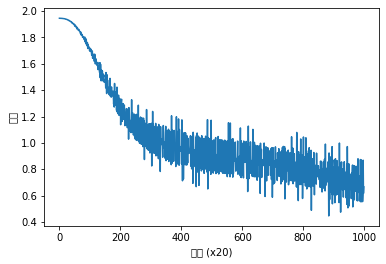

you [-0.9049717   0.8855667  -0.91776067 -0.93416846  1.6909319 ]
say [ 1.0968777 -1.1338617  1.1173865  1.0883389  1.2585019]
goodbye [-1.0198039   0.99971455 -1.0223242  -0.98361105 -0.02786337]
and [ 0.8826151  -0.66834205  0.8459068   1.0914882   1.8520579 ]
i [-1.0340393   0.97864354 -1.0342762  -1.001588   -0.04442818]
hello [-0.9331656   0.8978569  -0.9000251  -0.95148706  1.683233  ]
. [ 1.0566597  -1.3008856   1.1103171   0.65401864 -0.2025193 ]


In [18]:
import sys
sys.path.append('..')  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import preprocess, create_contexts_target, convert_one_hot


window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

In [23]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [-0.9049717   0.8855667  -0.91776067 -0.93416846  1.6909319 ]
say [ 1.0968777 -1.1338617  1.1173865  1.0883389  1.2585019]
goodbye [-1.0198039   0.99971455 -1.0223242  -0.98361105 -0.02786337]
and [ 0.8826151  -0.66834205  0.8459068   1.0914882   1.8520579 ]
i [-1.0340393   0.97864354 -1.0342762  -1.001588   -0.04442818]
hello [-0.9331656   0.8978569  -0.9000251  -0.95148706  1.683233  ]
. [ 1.0566597  -1.3008856   1.1103171   0.65401864 -0.2025193 ]


가중치를 출력한 결과 단어 ID의 분산표현이 담겨있는 것을 알 수 있다.

## 3.5 word2vec 보충

CBOW모델을 확률관점에서 보자.
![image](https://user-images.githubusercontent.com/63278762/135194043-d5ece680-f28e-4f94-bf60-a44656d1377f.png)

$W_{t-1}$과 $W_{t+1}$이 주어졌을 때 $W_t$가 될 확률
$$P(W_t|W_{t-1},W_{t+1})$$
사후확률을 이용해 위와같이 쓸 수 있다.
> 사후확률 : 관측이나 증거에 대한 조건부 확률

위의 식을 이용해 CBOW의 loss 함수를 간단하게 만들 수 있다. 
![image](https://user-images.githubusercontent.com/63278762/135221096-8672c511-9995-42f8-83e9-0c67b2195025.png)

이를 **음의 로그 가능도**라고 부른다. 이것을 말뭉치 전체로 확장하면 다음의 식이 된다.
![image](https://user-images.githubusercontent.com/63278762/135221465-b2a0aae9-3dda-461d-9ece-6f9ed67950a5.png)

### 3.5.2 skip-gram 모델
word2vec은 2개의 모델을 제안한다.
1. CBOW
2. skip-gram

여기서 skip-gram은 CBOW에서 다루는 contexts와 target을 역전시킨 모델이다. 

![image](https://user-images.githubusercontent.com/63278762/135222442-c06b94d0-d1f8-4a5c-adc5-1c63f349af4f.png)

중앙 단어(target)으로부터 주변 여러단어(contexts)를 추측

![image](https://user-images.githubusercontent.com/63278762/135223056-d772bfe9-ffac-458a-8059-324fad3e2e47.png)

입력층이 하나이고 출력층은 contexts의 수만큼 존재한다. 각 출력층에서는 각각의 Loss를 먼저 구하고, 구해진 Loss들을 모두 더한 값이 최종 Loss가 된다.    
skip-gram 모델을 확률로 표기해보면 
![image](https://user-images.githubusercontent.com/63278762/135223286-35a3d917-1809-408d-b3b7-7b167cfee071.png)

$W_t$가 일어났을 때 $W_{t-1}$, $W_{t+1}$이 동시에 일어날 확률.    
skip-gram은 contexts들 사이 관련성이 없다고 가정하고 분해를 한다.(조건부 독립)

![image](https://user-images.githubusercontent.com/63278762/135223534-415a590f-8c15-4f1e-a66f-b52bc15fc5ae.png)

교차 엔트로피 오차를 적용하면 

![image](https://user-images.githubusercontent.com/63278762/135224116-8d469a82-1008-4f00-b713-8d73baad2a04.png)

말뭉치 전체로 확장한 손실함수
![image](https://user-images.githubusercontent.com/63278762/135224138-8b8988c7-237c-4f68-a959-00ee7cb556ff.png)


* CBOW 모델은 타깃 하나의 손실을 구하고, skip-gram은 각 맥락에서 구한 손실의 총합을 구한다.

##### 그렇다면 CBOW와 skip-gram 중 어떤 것을 사용해야 할까?
여기서는 skip-gram 모델의 결과가 더 좋은 경우가 많다. 특히 말뭉치가 커질수록 저빈도 단어나 유추 문제의 성능 면에서 skip-gram 모델이 더 뛰어나다.    
반면, 속도 면에서는 CBOW 모델이 더 빠르다. 

=> skip-gram은 기울기랑 loss도 두개로 계산. 더 어려운 모델이라 오래걸린다.

In [24]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0])
        l2 = self.loss_layer2.forward(s, contexts[:, 1])
        loss = l1 + l2
        return loss

    def backward(self, dout=1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        return None

### 3.5.3 통계 기반 vs. 추론 기반
#### 통계기반
말뭉치 전체 통계로부터 1회 학습해 단어의 분산 표현을 얻음.
* 새로운 단어를 추가할 때 : 처음부터 다시 계산해야 한다.
* 단어의 유사성이 인코딩된다.

#### 추론기반
말뭉치를 조금씩 여러번 보며 학습(미니배치)
* 새로운 단어를 추가할 때 : 기존에 학습한 가중치를 초깃값으로 다시 학습시킨다.
* 단어의 유사성과 더 복잡한 단어 사이 패턴도 인코딩 된다.


하지만 유사성을 평가했을 때 통계기반과 추론기반의 우열을 가릴 수 없다.    
또, 추론 기반과 통계 기반은 서로 관련되어 있다. skip-gram과 네거티브 샘플링을 이용한 모델은 모두 말뭉치 전체의 동시발생 행렬에 특수한 행렬 분해를 적용한 것과 같다. 

word2vec 이후 추론 기반과 통계 기반을 융합한 GloVe 기법이 등장했다.    
기본 아이디어는 말뭉치 전체의 통계 정보를 손실 함수에 도입해 미니배치 학습을 하는 것이다.



## Summary
* 추론 기반 기법은 추측을 해서 단어의 분산 표현을 얻는 것이다.
* word2vec은 추론 기반 기법이고 단순한 2층 신경망이다.
* word2vec은 skip-gram 모델과 CBOW 모델을 제공한다.
* CBOW 모델은 여러 단어로부터 하나의 단어를 추측한다.
* skip-gram 모델은 하나의 단어로부터 여러 단어를 추측한다.
* word2vec은 가중치를 다시 학습할 수 있으므로, 단어의 분산 표현 갱신이나 새로운 단어 추가를 효율적으로 수행할 수 있다. 
